In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Data Read & Clean

In [2]:
df = pd.read_csv('rollingsales_consolidated.csv', encoding='latin-1', low_memory=False)
df = df.dropna(axis=1, how='all') #dropping empty columns (columns with only 'NaN')

In [3]:
df = df[[x for x in list(df) if len(df[x].unique())>1]] #dropping columns with only 1 value

In [4]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE']) #change date column type to datetime

In [5]:
df = df[df.SALE_PRICE >= 1000] #drop sales below $1000

# Sale Price Distribution Analysis

## Setup

In [6]:
sale_price = df['SALE_PRICE']

In [7]:
sale_price.describe().round(0)

count        48789.0
mean       1932823.0
std       10573201.0
min           1000.0
25%         512499.0
50%         825000.0
75%        1400000.0
max      963000000.0
Name: SALE_PRICE, dtype: float64

Initial assessment of the price of the sale in the dataset suggests that in 2024:

- The average sale price in New York based on the dataset is $1,932,823.

- The median sale price in New York based on the dataset is $825,000.

- The highest sale price in New York based on the dataset is $963,000,000.

This also implies that the distribution of prices is skewed to the right (median < mean), meaning that the prices are more condensed in the lower numbers, and more spreaded out in the higher numbers.

## Outlier Analysis

In [8]:
#function to remove outliers
def outlierbounds(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    iqr = q3-q1
    low_bound = q1-1.5*iqr
    hi_bound = q3+1.5*iqr
    return [low_bound,hi_bound]

Outliers are defined in skewed distributions as data points that are:

- Lower than Q1 - 1.5(IQR) (Lower Bound)
- Higher than Q3 + 1.5(IQR) (Higher Bound)

where Q1 is the first quartile/25th percentile, Q3 is the third quartile/75th percentile, and IQR is the Interquartile Range (difference between Q1 and Q3)

In [9]:
bounds = outlierbounds(sale_price)
bounds

[-818752.5, 2731251.5]

The outliers are prices outside the range above. Since there are no negative prices, the outliers are sales above $2,731,251.

Note that outliers are in the sense that these prices differ too greatly from the majority of the sales in the dataset in order to identify distribution of the prices.

## Overall Prices

In [10]:
sale_price_adj = sale_price[(sale_price<=bounds[1])] #remove outliers outside the bounds

### Histogram

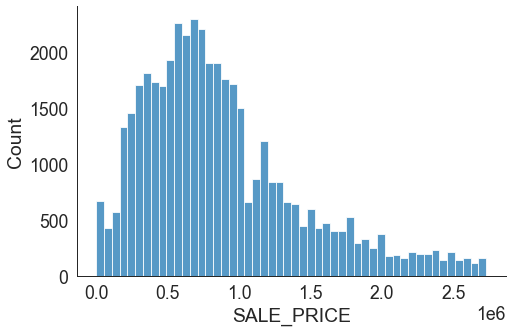

In [11]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=sale_price_adj, kind="hist", bins = 50, aspect = 1.5)

The histogram visual above confirms the initial assessment that the distribution of prices is skewed to the right.

### Fitting a distribution

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,1.427240e-12,3074.452351,3100.503951,0.054488,0.036332,1.708940e-50
gamma,1.525999e-12,3069.289627,3095.341228,0.058748,0.048213,1.312463e-88
rayleigh,2.193211e-12,3080.029932,3097.397666,0.088525,0.093925,0.000000e+00
chi2,2.328453e-12,3118.197195,3144.248796,0.099629,0.067756,1.152700e-174
cauchy,2.577844e-12,3138.674572,3156.042306,0.089169,0.120819,0.000000e+00


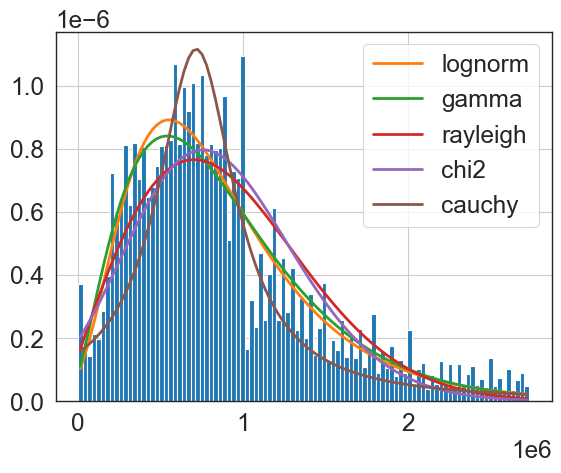

In [12]:
from fitter import Fitter, get_common_distributions, get_distributions
f = Fitter(sale_price_adj,
           distributions=get_common_distributions())
f.fit()
f.summary()

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the lognorm fit fits the data the best (least error)

In [13]:
ovr_dist = f.get_best(method = 'sumsquare_error')
ovr_dist #parameters of the fitted lognorm

{'lognorm': {'s': 0.4608460521751232,
  'loc': -321182.1696214488,
  'scale': 1079577.1423788979}}

In [14]:
s = ovr_dist['lognorm']['s']
sc = ovr_dist['lognorm']['scale']
lc = ovr_dist['lognorm']['loc']
from scipy.stats import lognorm
ovr = lognorm.rvs(s=s, loc=lc, scale=sc, size=100000) #generate random sample from the lognorm distribution

C:\Users\under\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


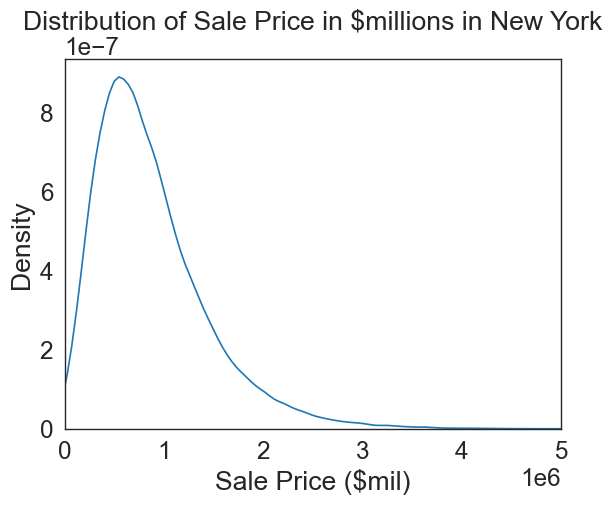

In [15]:
fig, ax = plt.subplots()
sns.distplot(ovr, hist=False)
ax.set_title("Distribution of Sale Price in $millions in New York")
ax.set_xlabel("Sale Price ($mil)")
ax.set_xlim(0,5000000)
plt.show()

The visual above shows the shape of the fitted distribution to the data (Log-Normal Distribution)

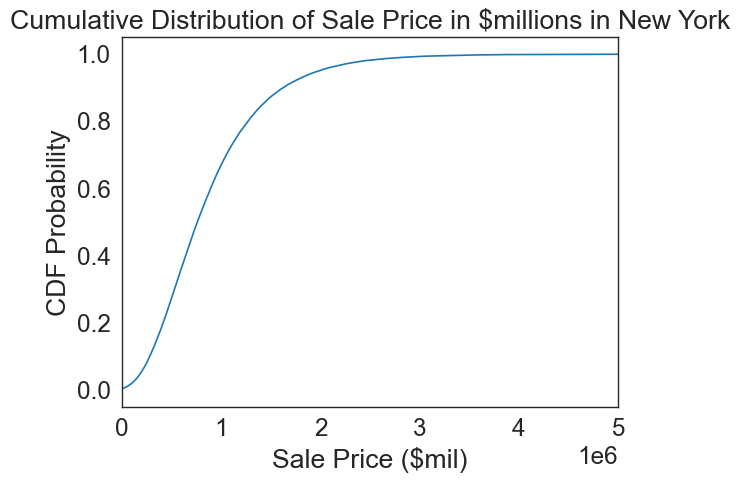

In [16]:
count, bins_count = np.histogram(ovr,bins = 1000)
pdf = count/sum(count)
cdf = np.cumsum(pdf)
fig, ax = plt.subplots()
plt.plot(bins_count[1:], cdf, label="CDF")
ax.set_title("Cumulative Distribution of Sale Price in $millions in New York")
ax.set_xlabel("Sale Price ($mil)")
ax.set_ylabel("CDF Probability")
ax.set_xlim(0,5000000)
plt.show()

The visual above shows the cumulative proability of the sale price. For example, based on the visual above, approximately 60% (0.6) of the sales are \\$1 million or under. Note that from this visual it can also be concluded that around 90-95\% of the sales are under \\$2 million.

## Borough Prices

In [17]:
df['BOROUGH_NAME'].unique() #Boroughs in New York

array(['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [18]:
df.groupby('BOROUGH_NAME')['SALE_PRICE'].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
BOROUGH_NAME,,,,,,,,
BRONX,3868.0,1054652.0,1995032.0,1000.0,314125.0,637250.0,920000.0,46440000.0
BROOKLYN,12669.0,1750212.0,5672035.0,1000.0,610950.0,990000.0,1680800.0,248000000.0
MANHATTAN,12915.0,3695707.0,19344637.0,1000.0,677250.0,1237500.0,2560000.0,963000000.0
QUEENS,14785.0,1147915.0,3033935.0,1000.0,400000.0,700000.0,995000.0,81850000.0
STATEN ISLAND,4552.0,734989.0,853244.0,1000.0,458875.0,650000.0,825000.0,15500000.0


Initial assessment of the price of the sale in the dataset suggests that in 2024:

- Manhattan has the highest average sale price in New York based on the dataset with $3,695,707.

- Staten Island has the lowest average sale price in New York based on the dataset with $734,989.

- Bronx and Staten Island have significantly lower number of sales compared to the other boroughs (lower counts).

- Manhattan has the highest spread of prices in New York (highest std).

- All boroughs have a right-skewed distribution (mean > median)

### Remove Outliers

In [19]:
sp_manhattan = df[df['BOROUGH_NAME']=="MANHATTAN"]['SALE_PRICE']
sp_bronx = df[df['BOROUGH_NAME']=="BRONX"]['SALE_PRICE']
sp_brooklyn = df[df['BOROUGH_NAME']=="BROOKLYN"]['SALE_PRICE']
sp_queens = df[df['BOROUGH_NAME']=="QUEENS"]['SALE_PRICE']
sp_staten = df[df['BOROUGH_NAME']=="STATEN ISLAND"]['SALE_PRICE']
bounds_mn = outlierbounds(sp_manhattan)
bounds_bx = outlierbounds(sp_bronx)
bounds_bk = outlierbounds(sp_brooklyn)
bounds_qn = outlierbounds(sp_queens)
bounds_si = outlierbounds(sp_staten)
sp_mn_adj = sp_manhattan[(sp_manhattan<=bounds_mn[1])]
sp_bx_adj = sp_bronx[(sp_bronx<=bounds_bx[1])]
sp_bk_adj = sp_brooklyn[(sp_brooklyn<=bounds_bk[1])]
sp_qn_adj = sp_queens[(sp_queens<=bounds_qn[1])]
sp_si_adj = sp_staten[(sp_staten<=bounds_si[1])]

### Manhattan Price Distribution

{'lognorm': {'s': 0.6727061744859424,
  'loc': -180359.24815731883,
  'scale': 1317595.0539062433}}

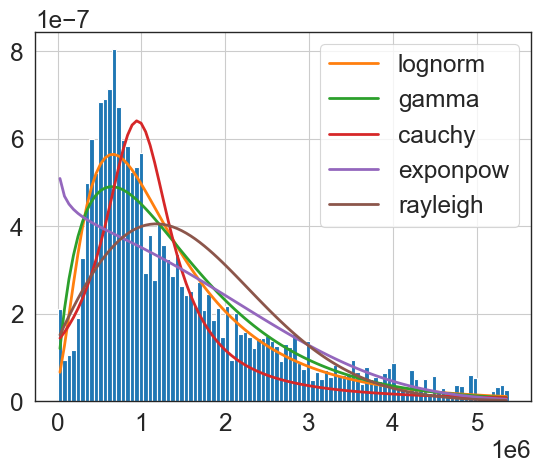

In [20]:
fm = Fitter(sp_mn_adj,
           distributions=get_common_distributions())
fm.fit()
fm.summary()
m_dist = fm.get_best(method = 'sumsquare_error')
m_dist

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the lognorm fit fits the data the best (least error)

### Bronx Price Distribution

{'rayleigh': {'loc': -53223.24296695167, 'scale': 515742.1332211283}}

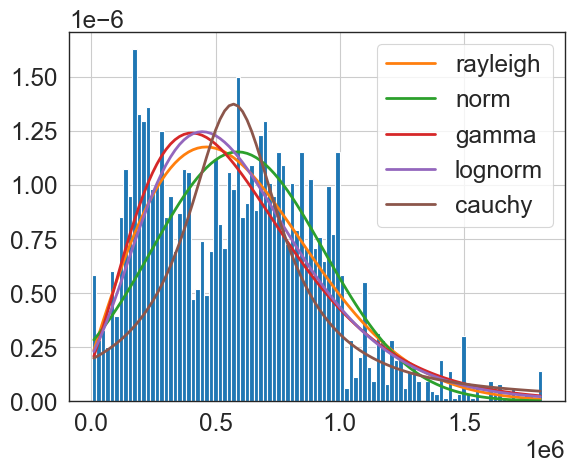

In [21]:
fx = Fitter(sp_bx_adj,
           distributions=get_common_distributions())
fx.fit()
fx.summary()
x_dist = fx.get_best(method = 'sumsquare_error')
x_dist

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the rayleigh fit fits the data the best (least error)

### Brooklyn Price Distribution

{'lognorm': {'s': 0.42723439651456124,
  'loc': -522899.53337730205,
  'scale': 1471338.0847440232}}

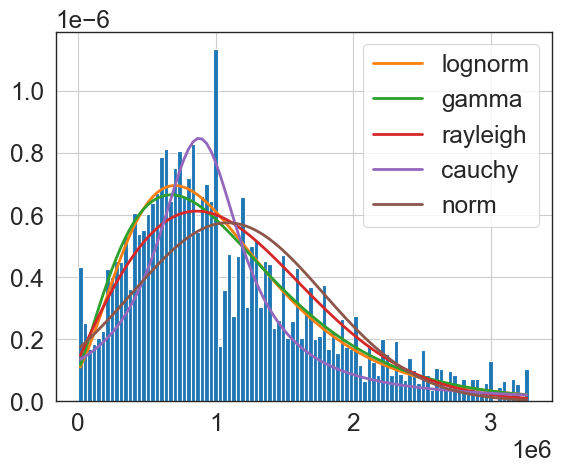

In [22]:
fk = Fitter(sp_bk_adj,
           distributions=get_common_distributions())
fk.fit()
fk.summary()
k_dist = fk.get_best(method = 'sumsquare_error')
k_dist

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the lognorm fit fits the data the best (least error)

### Queens Price Distribution

{'rayleigh': {'loc': -29365.9267085392, 'scale': 590331.1562467479}}

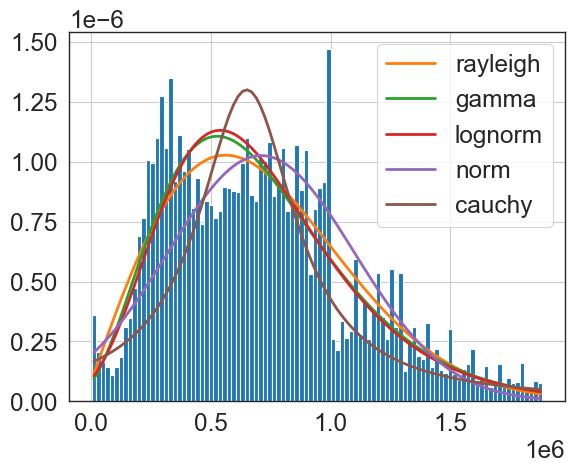

In [23]:
fq = Fitter(sp_qn_adj,
           distributions=get_common_distributions())
fq.fit()
fq.summary()
q_dist = fq.get_best(method = 'sumsquare_error')
q_dist

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the rayleigh fit fits the data the best (least error)

### Staten Island Price Distribution

{'norm': {'loc': 625873.2554610255, 'scale': 276168.9558001555}}

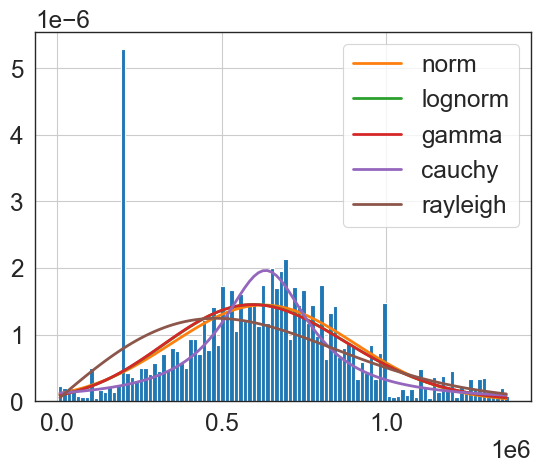

In [24]:
fs = Fitter(sp_si_adj,
           distributions=get_common_distributions())
fs.fit()
fs.summary()
s_dist = fs.get_best(method = 'sumsquare_error')
s_dist

The visual above (colored lines) shows possible distribution fits to the data. Based on the sum-squared errors, the normal fit fits the data the best (least error)

In [25]:
lm = m_dist['lognorm']['loc']
scm = m_dist['lognorm']['scale']
sm = m_dist['lognorm']['s']
sx = x_dist['rayleigh']['scale']
lk = k_dist['lognorm']['loc']
sck = k_dist['lognorm']['scale']
sk = k_dist['lognorm']['s']
sq = q_dist['rayleigh']['scale']
ls = s_dist['norm']['loc']
ss = s_dist['norm']['scale']

### Compare Distributions

C:\Users\under\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\under\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\under\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

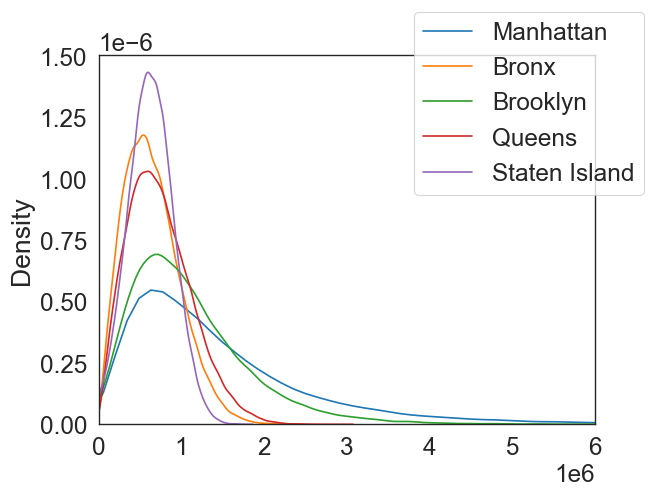

In [26]:
from scipy.stats import lognorm
fig, ax = plt.subplots()
manhattan = lognorm.rvs(s=sm, loc=lm, scale=scm, size=100000)
bronx = np.random.rayleigh(scale=sx, size=100000)
brooklyn = lognorm.rvs(s=sk, loc=lk, scale=sck, size=100000)
queens = np.random.rayleigh(scale=sq, size=100000)
staten = np.random.normal(loc=ls,scale=ss, size=100000)
sns.distplot(manhattan, hist=False)
sns.distplot(bronx, hist=False)
sns.distplot(brooklyn, hist=False)
sns.distplot(queens, hist=False)
sns.distplot(staten, hist=False)
ax.set_xlim(0,6000000)
fig.legend(labels=['Manhattan','Bronx','Brooklyn','Queens','Staten Island'])
plt.show()

The visual above confirms that:

- All boroughs are skewed to the right.

- Manhattan has the most spread of prices, and Staten Island has the least spread of prices.

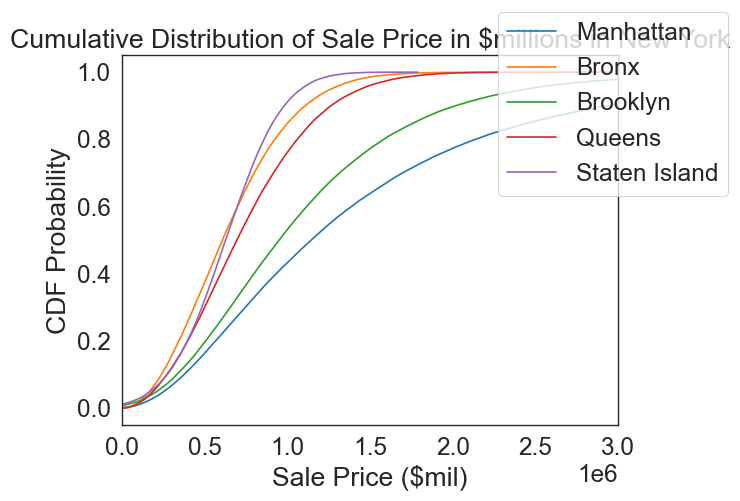

In [27]:
count_m, bins_count_m = np.histogram(manhattan,bins = 1000)
pdf_m = count_m/sum(count_m)
cdf_m = np.cumsum(pdf_m)
count_x, bins_count_x = np.histogram(bronx,bins = 1000)
pdf_x = count_x/sum(count_x)
cdf_x = np.cumsum(pdf_x)
count_k, bins_count_k = np.histogram(brooklyn,bins = 1000)
pdf_k = count_k/sum(count_k)
cdf_k = np.cumsum(pdf_k)
count_q, bins_count_q = np.histogram(queens,bins = 1000)
pdf_q = count_q/sum(count_q)
cdf_q = np.cumsum(pdf_q)
count_s, bins_count_s = np.histogram(staten,bins = 1000)
pdf_s = count_s/sum(count_s)
cdf_s = np.cumsum(pdf_s)


fig, ax = plt.subplots()
plt.plot(bins_count_m[1:], cdf_m, label="CDF")
plt.plot(bins_count_x[1:], cdf_x, label="CDF")
plt.plot(bins_count_k[1:], cdf_k, label="CDF")
plt.plot(bins_count_q[1:], cdf_q, label="CDF")
plt.plot(bins_count_s[1:], cdf_s, label="CDF")
ax.set_title("Cumulative Distribution of Sale Price in $millions in New York")
ax.set_xlabel("Sale Price ($mil)")
ax.set_ylabel("CDF Probability")
fig.legend(labels=['Manhattan','Bronx','Brooklyn','Queens','Staten Island'])
ax.set_xlim(0,3000000)
plt.show()

The visual above confirms that Manhattan and Brooklyn generally have higher sale prices than the other 3 boroughs (higher 90th percentile).

### Boxplots Comparison

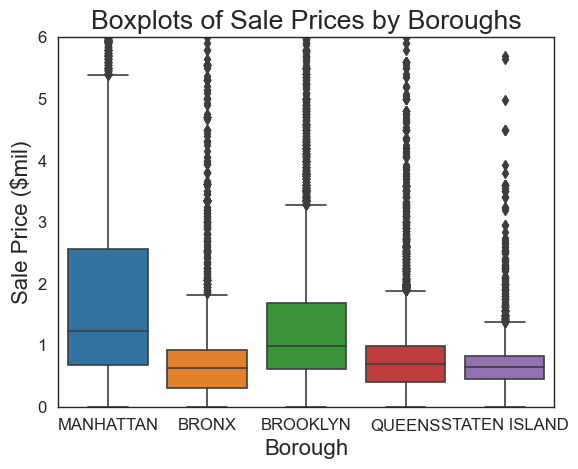

In [28]:
fig, ax = plt.subplots()
sns.boxplot(x=df["BOROUGH_NAME"],y=df["SALE_PRICE"]/1000000)
ax.tick_params(labelsize = 12)
ax.set_title("Boxplots of Sale Prices by Boroughs")
ax.set_xlabel("Borough", fontsize=16)
ax.set_ylabel("Sale Price ($mil)", fontsize=16)
ax.set_ylim(0,6)
plt.show()

The visual above confirms that:

- All boroughs are skewed to the right (higher numbers).

- Manhattan has the most spread of prices, and Staten Island has the least spread of prices.

- Manhattan has the largest average sale price.

The visual is however ambiguous regarding the average and spread of the sale price of Bronx, Queens, and Staten Island.

### ANOVA

The ANOVA test (one-way) examines whether the different borough sale prices are conclusively different from each other. If p-value < 0.05, it rejects the idea that the boroughs are NOT different from each other.

In [29]:
from scipy.stats import f_oneway
f_oneway(sp_manhattan,sp_bronx,sp_brooklyn,sp_queens,sp_staten) #complete data w/ outliers

F_onewayResult(statistic=133.7889277762654, pvalue=7.07185081486727e-114)

In [30]:
f_oneway(sp_mn_adj,sp_bx_adj,sp_bk_adj,sp_qn_adj,sp_si_adj) #without outliers

F_onewayResult(statistic=2374.6073981711165, pvalue=0.0)

Both one-way ANOVAs reject the null hypothesis, concluding that at least one of the boroughs has conclusively higher or lower sale prices compared to the other boroughs.

### Tukey-HSD

The Tukey-HSD test takes each combination of 2 boroughs, and examines whether they conclusively have different sale prices (reject = True means that they are different from each other, False means that they are not conclusively different).

In [31]:
df.groupby('BOROUGH_NAME')['SALE_PRICE'].describe().round(0)['mean'].sort_values(ascending=False)

BOROUGH_NAME
MANHATTAN        3695707.0
BROOKLYN         1750212.0
QUEENS           1147915.0
BRONX            1054652.0
STATEN ISLAND     734989.0
Name: mean, dtype: float64

Note that even though they have different mean values (ex. Queens > Bronx), it does not mean that sale prices are definitively higher in Queens than Bronx. It might just be caused by random sampling of sales. This test examines if they are actually different outside of the random sampling.

In [32]:
import statsmodels.stats.multicomp as mc
print(mc.pairwise_tukeyhsd(df['SALE_PRICE'],df['BOROUGH_NAME'],0.05))

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
  group1      group2       meandiff   p-adj      lower         upper     reject
-------------------------------------------------------------------------------
    BRONX      BROOKLYN   695559.9773 0.0029   168584.7658  1222535.1887   True
    BRONX     MANHATTAN  2641055.3184  0.001  2115255.3161  3166855.3207   True
    BRONX        QUEENS    93263.4037    0.9  -424816.4117   611343.2191  False
    BRONX STATEN ISLAND   -319662.716 0.6165  -946980.9493   307655.5174  False
 BROOKLYN     MANHATTAN  1945495.3411  0.001  1586786.5055  2304204.1767   True
 BROOKLYN        QUEENS  -602296.5736  0.001  -949590.5146  -255002.6326   True
 BROOKLYN STATEN ISLAND -1015222.6932  0.001 -1510938.8945   -519506.492   True
MANHATTAN        QUEENS -2547791.9147  0.001 -2893300.0194   -2202283.81   True
MANHATTAN STATEN ISLAND -2960718.0344  0.001 -3455184.7381 -2466251.3306   True
   QUEENS STATEN ISLAND  -412926.1197 0.

From the analysis above, it can be concluded that Manhattan conclusively has the highest prices, with Brooklyn being 2nd. However, it also shows that the sale prices of the other 3 boroughs (Bronx, Queens, Staten Island) are not conclusively different from each other.

The stat above also shows how 2 boroughs are different from each other (for reject = True, alpha = 0.05). For example:

- Around 95% of sale prices in Brooklyn are in general \\$168,000 - \\$1,222,000 higher than in Bronx
- Around 95% of sale prices in Queens are in general \\$2,202,000 - \\$2,893,000 lower than in Manhattan
- Around 95% of sale prices in Manhattan are in general \\$2,466,000 - \\$3,455,000 lower than in Staten Island
- etc

# Effects of Building Lots on Sale Price

##### The effect of different building variables (ex. location, basement, etc.) to the unit prices in said buildings.

In [51]:
df_var = df[['NEIGHBORHOOD','BUILDING_CLASS_CATEGORY','address_pl','ext','proxcode','irrlotcode','lottype','bsmtcode',
             'SALE_PRICE']]
df_var = df_var.astype('object')
df_var['SALE_PRICE'] = df_var['SALE_PRICE'].astype('int64')
df_var = df_var[df_var['SALE_PRICE'] <= bounds[1]] #Outlier removal
df_var

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,address_pl,ext,proxcode,irrlotcode,lottype,bsmtcode,SALE_PRICE
0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,356 EAST 8 STREET,N,1.0,N,5.0,2.0,2000000
2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,745 EAST 6 STREET,N,0.0,N,5.0,0.0,625000
3,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,745 EAST 6 STREET,N,0.0,N,5.0,0.0,565000
4,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,719 EAST 6 STREET,N,3.0,N,5.0,2.0,168494
5,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,21 AVENUE C,N,0.0,N,5.0,0.0,163587
...,...,...,...,...,...,...,...,...,...
74073,WOODROW,02 TWO FAMILY DWELLINGS,18 SALAMANDER COURT,N,3.0,Y,5.0,4.0,790000
74075,WOODROW,02 TWO FAMILY DWELLINGS,131 DARNELL LANE,N,3.0,N,5.0,4.0,758000
74076,WOODROW,02 TWO FAMILY DWELLINGS,46 MANDY COURT,N,1.0,Y,5.0,2.0,995000
74079,WOODROW,02 TWO FAMILY DWELLINGS,49 QUAIL LANE,N,3.0,N,5.0,5.0,782000


## Extension

#### Identifying whether there is an extension on the lot or a garage other than the primary structure

E - Extension

G - Garage

EG - Extension & Garage

N - No Extensions

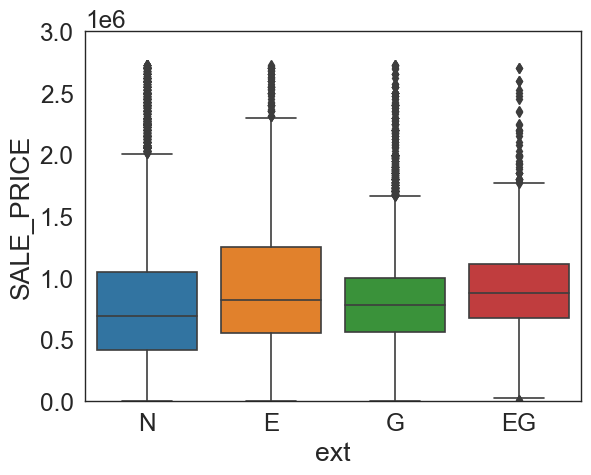

ext
E     958439.0
EG    926212.0
G     829191.0
N     822920.0
Name: SALE_PRICE, dtype: float64

In [75]:
df_ext = df_var[['ext','SALE_PRICE']].dropna()
fig, ax = plt.subplots()
sns.boxplot(data=df_ext, x="ext",y="SALE_PRICE")
ax.set_ylim(0,3000000)
plt.show()
df_ext.groupby('ext')['SALE_PRICE'].mean().round(0).sort_values(ascending=False) #mean values

In [62]:
n = df_var[df_var['ext']=="N"]['SALE_PRICE']
e = df_var[df_var['ext']=="E"]['SALE_PRICE']
g = df_var[df_var['ext']=="G"]['SALE_PRICE']
eg = df_var[df_var['ext']=="EG"]['SALE_PRICE']
print(f_oneway(n,e,g,eg)) ## ANOVA
print(mc.pairwise_tukeyhsd(df_ext['SALE_PRICE'],df_ext['ext'],0.05)) ## Tukey-HSD

F_onewayResult(statistic=40.311589754386205, pvalue=5.465135850361426e-26)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     E     EG  -32226.5192 0.4496  -88081.4433  23628.4049  False
     E      G  -129247.233  0.001 -167722.9514 -90771.5147   True
     E      N -135518.7615  0.001 -172255.2104 -98782.3126   True
    EG      G  -97020.7139  0.001 -142666.4906 -51374.9372   True
    EG      N -103292.2423  0.001 -147481.8644 -59102.6202   True
     G      N   -6271.5284 0.7742  -23972.6883  11429.6314  False
-----------------------------------------------------------------


Based on the boxplots and tests above:

- Boxplots do not conclusively show significant price differences between the groups

- ANOVA (p < 0.05) shows that at least one of the groups is different in price than the other groups

- Tukey-HSD shows that units with either an extension (E) or an extension + garage (EG) generally have higher sale prices than units with either a garage (G) or no extensions (N), implying that the presence of an extension generally drives up sale prices.

## Irregularity of Lot

#### Indicating whether the lot is irregularly shaped

Y - Irregular

N - Not Irregular

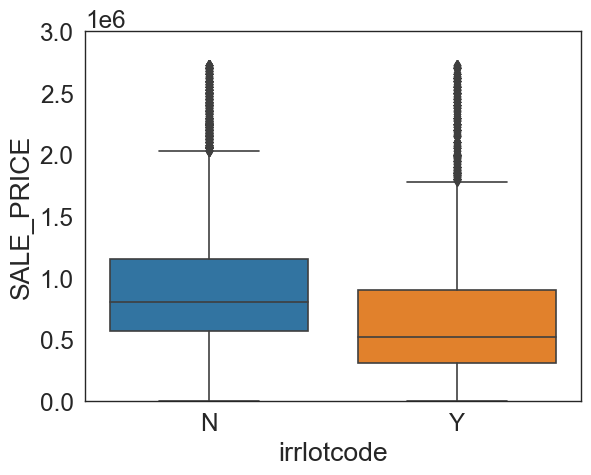

irrlotcode
N    901255.0
Y    690542.0
Name: SALE_PRICE, dtype: float64

In [77]:
df_irr = df_var[['irrlotcode','SALE_PRICE']].dropna()
fig, ax = plt.subplots()
sns.boxplot(data=df_irr, x="irrlotcode",y="SALE_PRICE")
ax.set_ylim(0,3000000)
plt.show()
df_irr.groupby('irrlotcode')['SALE_PRICE'].mean().round(0).sort_values(ascending=False)

In [64]:
n = df_var[df_var['irrlotcode']=="N"]['SALE_PRICE']
y = df_var[df_var['irrlotcode']=="Y"]['SALE_PRICE']
print(f_oneway(n,y))
print(mc.pairwise_tukeyhsd(df_irr['SALE_PRICE'],df_irr['irrlotcode'],0.05))

F_onewayResult(statistic=1088.6716287269671, pvalue=9.267847046500725e-235)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     N      Y -210712.8679 0.001 -223230.0716 -198195.6642   True
-----------------------------------------------------------------


Based on the boxplots and tests above:

- Boxplots show significant price difference between Y and N, with N being visibly higher in prices.

- ANOVA (p < 0.05) shows that Y and N have significantly different prices.

- Tukey-HSD shows that units in irregularly shaped lots (Y) generally have lower prices than units in regularly shaped lots (N).

## Proximity

#### Describing the physical relationship of the building to neighboring buildings

1 - Detached from neighboring building(s)

2 - Semi-attached to neighboring building(s)

3 - Attached to neighboring building(s)

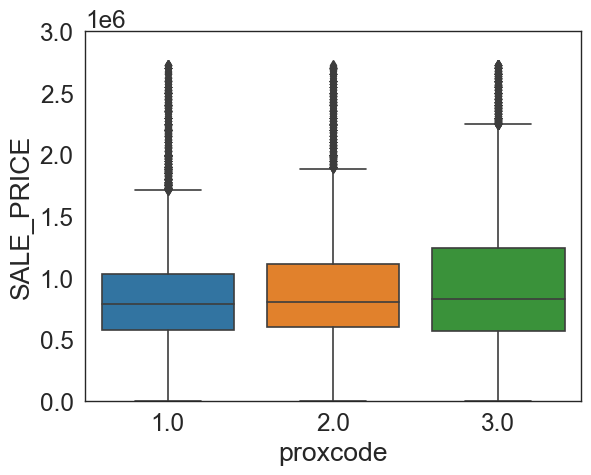

proxcode
3.0    960840.0
2.0    909486.0
1.0    855804.0
Name: SALE_PRICE, dtype: float64

In [96]:
df_prox = df_var[df_var['proxcode']!=0][['proxcode','SALE_PRICE']].dropna()
fig, ax = plt.subplots()
sns.boxplot(data=df_prox, x="proxcode",y="SALE_PRICE")
ax.set_ylim(0,3000000)
plt.show()
df_prox.groupby('proxcode')['SALE_PRICE'].mean().round(0).sort_values(ascending=False)

In [97]:
c1 = df_var[df_var['proxcode']==1]['SALE_PRICE']
c2 = df_var[df_var['proxcode']==2]['SALE_PRICE']
c3 = df_var[df_var['proxcode']==3]['SALE_PRICE']
print(f_oneway(c0,c1,c2,c3))
print(mc.pairwise_tukeyhsd(df_prox['SALE_PRICE'],df_prox['proxcode'],0.05))

F_onewayResult(statistic=69.70901450111256, pvalue=7.052170536591448e-45)
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj   lower       upper    reject
-------------------------------------------------------------
   1.0    2.0  53682.9103 0.001 35367.7488  71998.0717   True
   1.0    3.0 105036.2688 0.001 87059.4828 123013.0549   True
   2.0    3.0  51353.3586 0.001 31339.2125  71367.5046   True
-------------------------------------------------------------


Based on the boxplots and tests above:

- Boxplots do not conclusively show significant price differences between the groups

- ANOVA (p < 0.05) shows that at least one of the groups is different in price than the other groups

- Tukey-HSD shows that attached buildings have generally the highest prices, with semi-attached buildings 2nd, and detached buildings have the lowest prices

## Lot Type

#### Indicating the location of the tax lot in relationship to another tax lot and/or the water

1 - Block assemblage – a lot that encompasses an entire block

2 - Waterfront – a lot bordering on a body of water. Waterfront lots may contain a small amount of submerged land

3 - Corner – a lot bordering on two intersecting streets

4 - Through – a lot connecting two streets, with frontage on both streets

5 - Inside – a lot with frontage on only one street

6 - Interior lot – a lot that has no street frontage

7 - Island lot – a lot that is entirely surrounded by water

8 - Alley lot – a lot that is too narrow to accommodate a building. The lot is usually 12 feet or less in width

9 - Submerged land lot – a tax lot that is totally or almost completely submerged


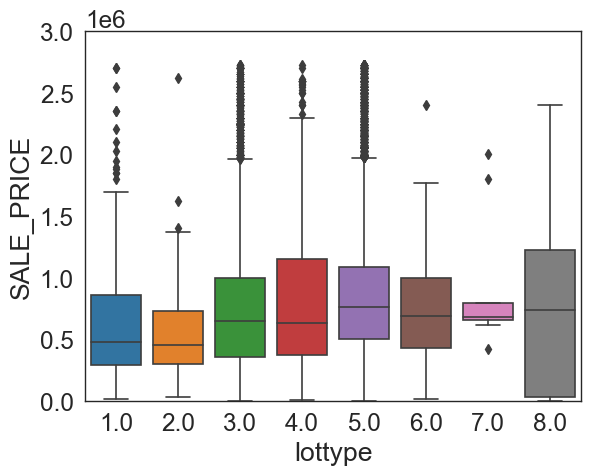

lottype
7.0    933213.0
5.0    854047.0
4.0    850837.0
3.0    784961.0
8.0    763403.0
6.0    740321.0
1.0    662562.0
2.0    581539.0
Name: SALE_PRICE, dtype: float64

In [94]:
df_lot = df_var[df_var['lottype']!=0][['lottype','SALE_PRICE']].dropna()
fig, ax = plt.subplots()
sns.boxplot(data=df_lot, x="lottype",y="SALE_PRICE")
ax.set_ylim(0,3000000)
plt.show()
df_lot.groupby('lottype')['SALE_PRICE'].mean().round(0).sort_values(ascending=False)

In [95]:
c1 = df_var[df_var['lottype']==1]['SALE_PRICE']
c2 = df_var[df_var['lottype']==2]['SALE_PRICE']
c3 = df_var[df_var['lottype']==3]['SALE_PRICE']
c4 = df_var[df_var['lottype']==4]['SALE_PRICE']
c5 = df_var[df_var['lottype']==5]['SALE_PRICE']
c6 = df_var[df_var['lottype']==6]['SALE_PRICE']
c7 = df_var[df_var['lottype']==7]['SALE_PRICE']
c8 = df_var[df_var['lottype']==8]['SALE_PRICE']
print(f_oneway(c1,c2,c3,c4,c5,c6,c7,c8))
print(mc.pairwise_tukeyhsd(df_lot['SALE_PRICE'],df_lot['lottype'],0.05))

F_onewayResult(statistic=19.798211289810038, pvalue=1.1577007197629571e-26)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
   1.0    2.0  -81022.8346    0.9 -307140.4051 145094.7359  False
   1.0    3.0  122399.3735 0.0037   24686.9167 220111.8303   True
   1.0    4.0  188275.0272  0.001    66162.184 310387.8705   True
   1.0    5.0  191484.7225  0.001   95145.4955 287823.9495   True
   1.0    6.0   77758.9451    0.9 -172225.5236 327743.4138  False
   1.0    7.0  270651.1326 0.7742 -271143.5753 812445.8406  False
   1.0    8.0  100841.2095    0.9 -227195.9292 428878.3483  False
   2.0    3.0  203422.2081 0.0553   -2321.6516 409166.0678  False
   2.0    4.0  269297.8618 0.0046   50907.4818 487688.2418   True
   2.0    5.0  272507.5571 0.0015   67412.3152  477602.799   True
   2.0    6.0  158781.7797 0.7472 -149884.7817 467448.3412  False


Based on the boxplots and tests above:

- Boxplots do not conclusively show significant price differences between the groups

- ANOVA (p < 0.05) shows that at least one of the groups is different in price than the other groups

- Tukey-HSD shows that generally buildings that are considered in Block Assemblage, Waterfront, and Corner lots (1,2,3) have lower prices than other types of lots.

## Basement Availability

#### Describing the building’s basement

0 - No Basement Available

1 - Above grade full basement – the basement is 75% or more of the area of the first floor and the basement walls are at least 4 feet high on at least two sides 

2 - Below grade full basement – the basement is 75% or more of the area of the first floor and the basement walls are fully submerged or are less than 4 feet on at least three sides

3 - Above grade partial basement – the basement is between 25% and 75% of the area of the first floor and the basement walls are at least 4 feet high on at least two sides

4 - Below grade partial basement – the basement is between 25% and 75% of the area of the first floor and the basement walls are fully submerged or are less than 4 feet on at least three sides


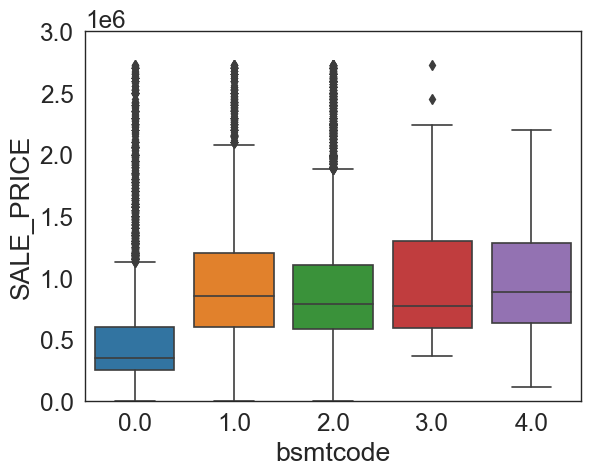

bsmtcode
3.0    1004846.0
4.0     987080.0
1.0     936830.0
2.0     893784.0
0.0     550484.0
Name: SALE_PRICE, dtype: float64

In [98]:
df_bsmt = df_var[df_var['bsmtcode']!=5][['bsmtcode','SALE_PRICE']].dropna()
fig, ax = plt.subplots()
sns.boxplot(data=df_bsmt, x="bsmtcode",y="SALE_PRICE")
ax.set_ylim(0,3000000)
plt.show()
df_bsmt.groupby('bsmtcode')['SALE_PRICE'].mean().round(0).sort_values(ascending=False)

In [99]:
c1 = df_var[df_var['bsmtcode']==1]['SALE_PRICE']
c2 = df_var[df_var['bsmtcode']==2]['SALE_PRICE']
c3 = df_var[df_var['bsmtcode']==3]['SALE_PRICE']
c4 = df_var[df_var['bsmtcode']==4]['SALE_PRICE']
c5 = df_var[df_var['bsmtcode']==0]['SALE_PRICE']
print(f_oneway(c1,c2,c3,c4,c0))
print(mc.pairwise_tukeyhsd(df_bsmt['SALE_PRICE'],df_bsmt['bsmtcode'],0.05))

F_onewayResult(statistic=12.923572050060592, pvalue=1.6417064464400263e-10)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
   0.0    1.0 386345.9289  0.001  359718.1111 412973.7467   True
   0.0    2.0 343299.9944  0.001  322692.0279  363907.961   True
   0.0    3.0 454362.3831  0.001  253577.5903 655147.1759   True
   0.0    4.0 436596.1343  0.001  305241.7429 567950.5257   True
   1.0    2.0 -43045.9345  0.001  -65316.3096 -20775.5594   True
   1.0    3.0  68016.4542 0.8814  -132945.767 268978.6753  False
   1.0    4.0  50250.2054 0.8143  -81375.2385 181875.6492  False
   2.0    3.0 111062.3887 0.5467  -89191.1055 311315.8829  False
   2.0    4.0  93296.1399 0.2912  -37244.6778 223836.9575  False
   3.0    4.0 -17766.2488    0.9 -256367.9038 220835.4062  False
----------------------------------------------------------------


Based on the boxplots and tests above:

- Boxplots visibly shows that no-basement buildings (0) have significantly lower prices than the other 4 groups. However, they do not conclusively show significant price differences between the other 4 groups

- ANOVA (p < 0.05) shows that at least one of the groups is different in price than the other groups

- Tukey-HSD shows that no-basement buildings (0) have significantly lower prices than buildings with basements (1,2,3,4). It also shows that buildings with above grade full basements have conclusively higher prices than buildings with below grade full basements.

# Exploration Summary

Manhattan has generally the highest sale prices, with Brooklyn coming in 2nd. Queens, Staten Island, and Bronx generally have lower sale prices, with no significant difference in prices between each other. The buildings that house the units also affect the sale prices:

- Buildings with extensions generally have higher prices than buildings with only garages or no extensions.

- Buildings in irregularly shaped spaces generally have lower prices.

- Buildings that are attached to other buildings generally have higher prices than detached buildings.

- Buildings considered to be in Block Assemblage, Waterfront, and Corner lots generally have lower prices.

- Buildings with no basements generally have significantly lower prices. Also, buildings with above grade full basements have higher prices than buildings with below grade full basements.